In [ ]:
import os
import gc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

from sklearn.model_selection import train_test_split, GroupKFold
from sklearn.metrics import f1_score, make_scorer
from sklearn.model_selection import GridSearchCV

from xgboost import XGBClassifier

In [ ]:
# loading the train labels

labels_df = pd.read_csv('train_labels.csv')

labels_df['session'] = labels_df['session_id'].apply(lambda x: int(x.split('_')[0]))
labels_df['question'] = labels_df['session_id'].apply(lambda x: int(x.split('q')[1]))

labels_df = (
    labels_df
    .sort_values(by=['session', 'question'], ascending=[True, True])
    .reindex(columns=['session_id', 'session', 'question', 'correct'])
    .reset_index(drop=True)
    .drop(columns='session_id')
)

labels_df.head()

In [ ]:
# excluding cols to save memory
exclude_cols = ['index', 'fullscreen', 'hq', 'music', 'text']

# borrowing the dtypes dictionary from a featured notebook
dtypes = {
    'elapsed_time':np.int32,
    'event_name':'category',
    'name':'category',
    'level':np.uint8,
    'room_coor_x':np.float32,
    'room_coor_y':np.float32,
    'screen_coor_x':np.float32,
    'screen_coor_y':np.float32,
    'hover_duration':np.float32,
    'text': 'category',
    'fqid': 'category',
    'room_fqid':'category',
    'text_fqid':'category',
    'fullscreen': bool,
    'hq':bool,
    'music': bool,
    'level_group':'category'
}

df = pd.read_csv('train.csv', usecols=lambda x: x not in exclude_cols, dtype=dtypes)

df = (
    df
    .sort_values(by=['session_id', 'level', 'elapsed_time'], ascending=[True, True, True])
    .reset_index(drop=True)
)

In [ ]:
# i like this feature and the code to produce it, but it may not be useful
# out for now
# def get_last_4(x):
#     return x.iloc[-4:]


# # get last 4 fqid
# fqid_df = df.groupby(['session_id', 'level_group'])['fqid'].apply(get_last_4).reset_index()
# fqid_df['entry_number'] = fqid_df.groupby(['session_id', 'level_group']).cumcount() + 1

# final_fqid = (
#     fqid_df
#     .pivot(index=['session_id', 'level_group'],
#            columns='entry_number',
#            values='fqid')
#     .rename(columns={1:'fqid_1back', 2:'fqid_2back', 3:'fqid_3back', 4:'fqid_4back'})
# )

# final_fqid

In [ ]:
def get_data_for_level(level_group=None, labels_df=labels_df):
    "gets group-level data to train models for each question"
    
    level_dict = {
        '0-4' : [1, 2, 3],
        '5-12' : [4, 5, 6, 7, 8, 9, 10, 11, 12, 13],
        '13-22' : [14, 15, 16, 17, 18]
    }

    
    df_ = df[df['level_group'] == level_group].copy()
    
    # getting elapsed diffs
    df_['event_time_delta'] = (
        df_
        .groupby('session_id')['elapsed_time']
        .transform(lambda x: x.diff().fillna(x.min()))
    )

    # getting the time until the next event
    df_['time_delta_til_next'] = (
        df_
        .groupby('session_id')['elapsed_time']
        .transform(lambda x: abs(x.diff(-1)).fillna(abs(x.min())))
    )
    
    # time delta means    
    time_delta_mean = df_.groupby('session_id').agg(event_time_mean=('event_time_delta', 'mean'),
                                                    event_time_std=('event_time_delta', 'std'),
                                                    event_time_max=('event_time_delta', 'max'))
    
    # total time on each event
    total_time_event = (
        df_
        .groupby(['session_id', 'event_name'])
        .agg(total_time=('time_delta_til_next', 'sum'))
        .unstack()
    )   
    
    # unique text ids
    nunique_text_ids = df_.groupby('session_id')['text_fqid'].nunique()
    
    # unique fqids 
    nunique_fqid = df_.groupby('session_id')['fqid'].nunique()
    
    # how many events of each type occurred in the session
    event_counts = df_.groupby('session_id')['event_name'].value_counts().unstack()
    
    # getting session lengths
    session_lengths = df_.groupby('session_id')['elapsed_time'].max().rename('total_length')
    
    # total events in the session
    session_events = df_.groupby('session_id')['session_id'].count()
    
    # getting labels
    session_labels = (
        labels_df
        .loc[labels_df.question.isin(level_dict[level_group])]
        .pivot(columns='question', values='correct', index='session')
    )
    
    # final df pre labels
    df_features = (
        pd.concat([total_time_event, nunique_text_ids, nunique_fqid, event_counts, session_lengths, session_events, time_delta_mean], axis=1)
    )
    
    # df with labels
    df_final = (
        pd.concat([df_features, session_labels], axis=1)
        .reset_index()
        .drop(columns=['session_id'])
        .rename(columns={'index' : 'session_id'})
    )
    
#     # extracting date and time data from the session_id
#     df_final['year'] = df_final['session_id'].apply(lambda x: int(str(x)[:2]))
#     df_final['month'] = df_final['session_id'].apply(lambda x: int(str(x)[2:4]))
#     df_final['day'] = df_final['session_id'].apply(lambda x: int(str(x)[4:6]))
#     df_final['hour'] = df_final['session_id'].apply(lambda x: int(str(x)[6:8]))

#     # creating a weekend indicator because weekends are different
#     df_final['weekend'] = np.where(df_final['day'].isin([6,0]), 1, 0)
    
    return df_final

In [ ]:
# creating a simple example to know what i'm doing
group_k_fold = GroupKFold(n_splits=5)

group1_data = get_data_for_level('5-12')

In [ ]:
# columns that routinely added zero or negative value in prelim tests
bad_cols = ['year', 'checkpoint', 'session_id', 'hour', 'day', 
            'weekend', 'fqid', 'notification_click', 'month', 
            'cutscene_click', 'observation_click']

level_dict = {
    '0-4' : [1, 2, 3],
    '5-12' : [4, 5, 6, 7, 8, 9, 10, 11, 12, 13],
    '13-22' : [14, 15, 16, 17, 18]
}

# standardized feature columns to simplify
feature_cols = [x for x in group1_data.columns if x not in level_dict['5-12']]
feature_cols = [x for x in feature_cols if x not in bad_cols]

In [139]:
# creating a df of the best params 

best_params_df = pd.DataFrame()

for question in range(1, 19):
    
    if question in [1, 2, 3]:
        df_ = get_data_for_level('0-4')
    elif question in [4, 5, 6, 7, 8, 9, 10, 11, 12, 13]:
        df_ = get_data_for_level('5-12')
    else:
        df_ = get_data_for_level('13-22')
    
    fold = 1
    
    model = XGBClassifier()
    cv_method = GroupKFold(n_splits=5)
    
    grid_params_ = {
        'n_estimators' : [25, 100, 150],
        'max_depth' : [3, 5, 6, 8],
        'min_child_weight' : [1, 5, 10]
    }
    
    X = df_[feature_cols]
    X_groups = df_['session_id'].values
    y = labels_df.loc[labels_df['question'] == question].set_index('session').loc[X_groups]['correct']
    
    
    gridsearch = GridSearchCV(model,
                              param_grid=grid_params_,
                              cv=cv_method.split(X, y, groups=X_groups),
                              scoring='f1_macro')    
    gridsearch.fit(X, y)
    
    best_depth = gridsearch.best_params_['max_depth']
    best_weight = gridsearch.best_params_['min_child_weight']
    best_score = gridsearch.best_score_
    best_estimators = gridsearch.best_params_['n_estimators']
    
    param_score_df_ = pd.DataFrame({
        'question' : question,
        'estimators' : best_estimators,
        'best_depth' : best_depth,
        'best_weight' : best_weight,
        'best_score' : best_score},
        index=[0]
    )
    
    best_params_df = pd.concat([best_params_df, param_score_df_])
    print(best_score, gridsearch.best_params_)

0.6057502114576481 {'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 100}
0.5137802285063735 {'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 150}
0.5085908009510599 {'max_depth': 8, 'min_child_weight': 10, 'n_estimators': 150}
0.6080037933764999 {'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 150}
0.6151541414032232 {'max_depth': 3, 'min_child_weight': 10, 'n_estimators': 25}
0.5710421940977841 {'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 150}
0.5475278256378877 {'max_depth': 8, 'min_child_weight': 10, 'n_estimators': 150}
0.5247914364711039 {'max_depth': 8, 'min_child_weight': 10, 'n_estimators': 150}
0.5643293657787121 {'max_depth': 8, 'min_child_weight': 10, 'n_estimators': 100}
0.6132823475036581 {'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 25}
0.5472687031870742 {'max_depth': 8, 'min_child_weight': 5, 'n_estimators': 150}
0.5029577936072773 {'max_depth': 8, 'min_child_weight': 5, 'n_estimators': 150}
0.5540712537408627 {'max_depth': 6, '

In [227]:
# getting the best params from the gridsearch
param_dict = best_params_df[['best_depth', 'best_weight']].to_dict()

# creating a groupkfold object
gkf = GroupKFold(n_splits=7)

# creating a dataframe to get the out of fold predictions
oof = pd.DataFrame(
    data=np.zeros((len(df['session_id'].unique()), 18)),
    index=df['session_id'].unique(),
)

# dictionary to keep the trained models
models = {}


for question in range(1, 19):
    if question in [1, 2, 3]:
        df_ = get_data_for_level('0-4')
    elif question in [4, 5, 6, 7, 8, 9, 10, 11, 12, 13]:
        df_ = get_data_for_level('5-12')
    else:
        df_ = get_data_for_level('13-22')
        
    for i, (train_index, test_index) in enumerate(gkf.split(X=df_, groups=df_['session_id'])):
        print(f"Fold {i + 1} => ", end="")
        
        # defining the params for the model, including the best params from gridsearch
        xgb_params = {
            "objective": "binary:logistic",
            "eval_metric": "logloss",
            "learning_rate": 0.05,
            "max_depth": param_dict['best_depth'][question - 1],
            "min_child_weight" : param_dict['best_weight'][question - 1],
            "n_estimators": 1000,
            "early_stopping_rounds": 50
        }

        # train data
        train_x = df_.iloc[train].copy()
        train_sessions = train_x['session_id'].values
        train_x = train_x[feature_cols].copy()
        train_y = labels_df.loc[labels_df['question'] == question].set_index('session').loc[train_sessions]['correct']

        # validate data
        val_x = df_.iloc[val].copy()
        val_sessions = val_x['session_id'].values
        val_x = val_x[feature_cols]
        val_y = labels_df.loc[labels_df['question'] == question].set_index('session').loc[val_sessions]['correct']

        # training the model using the params above
        clf = XGBClassifier(**xgb_params)
        
        clf.fit(
            train_x,
            train_y,
            eval_set=[(val_x, val_y)],
            verbose=0,
        )

        print(f"{question}({clf.best_ntree_limit}), ", end="")
        
        # putting the out of fold predictions into the dataframe
        oof.loc[val_sessions, question - 1] = clf.predict_proba(
            val_x[feature_cols])[:, 1]
        
        # adding the models to the model dictionary
        models[f'question_{question}'] = clf

Fold 1 => 1(100), Fold 2 => 1(100), Fold 3 => 1(100), Fold 4 => 1(100), Fold 5 => 1(100), Fold 6 => 1(100), Fold 7 => 1(100), Fold 1 => 2(192), Fold 2 => 2(192), Fold 3 => 2(192), Fold 4 => 2(192), Fold 5 => 2(192), Fold 6 => 2(192), Fold 7 => 2(192), Fold 1 => 3(98), Fold 2 => 3(98), Fold 3 => 3(98), Fold 4 => 3(98), Fold 5 => 3(98), Fold 6 => 3(98), Fold 7 => 3(98), Fold 1 => 4(90), Fold 2 => 4(90), Fold 3 => 4(90), Fold 4 => 4(90), Fold 5 => 4(90), Fold 6 => 4(90), Fold 7 => 4(90), Fold 1 => 5(269), Fold 2 => 5(269), Fold 3 => 5(269), Fold 4 => 5(269), Fold 5 => 5(269), Fold 6 => 5(269), Fold 7 => 5(269), Fold 1 => 6(74), Fold 2 => 6(74), Fold 3 => 6(74), Fold 4 => 6(74), Fold 5 => 6(74), Fold 6 => 6(74), Fold 7 => 6(74), Fold 1 => 7(70), Fold 2 => 7(70), Fold 3 => 7(70), Fold 4 => 7(70), Fold 5 => 7(70), Fold 6 => 7(70), Fold 7 => 7(70), Fold 1 => 8(52), Fold 2 => 8(52), Fold 3 => 8(52), Fold 4 => 8(52), Fold 5 => 8(52), Fold 6 => 8(52), Fold 7 => 8(52), Fold 1 => 9(69), Fold 2 => 

In [228]:
# getting the out of fold predictions above zero
oof_cleaned = oof[oof > 0].dropna()

# finding the matching targets
target_df = (
    labels_df[labels_df['session'].isin(oof_cleaned.index)]
    .pivot(index='session', columns='question', values='correct')
)

# lists for scores and thresholds
scores = []
thresholds = []

best_score = 0
best_threshold = 0

# iterate over all the possible thresholds
for threshold in np.arange(0.4, 0.81, 0.01):    
    
    # get the preds
    pred_df = (oof_cleaned > threshold).astype(int)
    
    # using numpy concatenate to clean this up
    m = f1_score(np.concatenate(target_df.values),
                 np.concatenate(pred_df.values.round(0)),
                 average='macro')
    
    # appending to the dataframe
    scores.append(m)
    thresholds.append(threshold)
    
    # only change em if they exceed highest value so far
    if m > best_score:
        best_score = m
        best_threshold = threshold

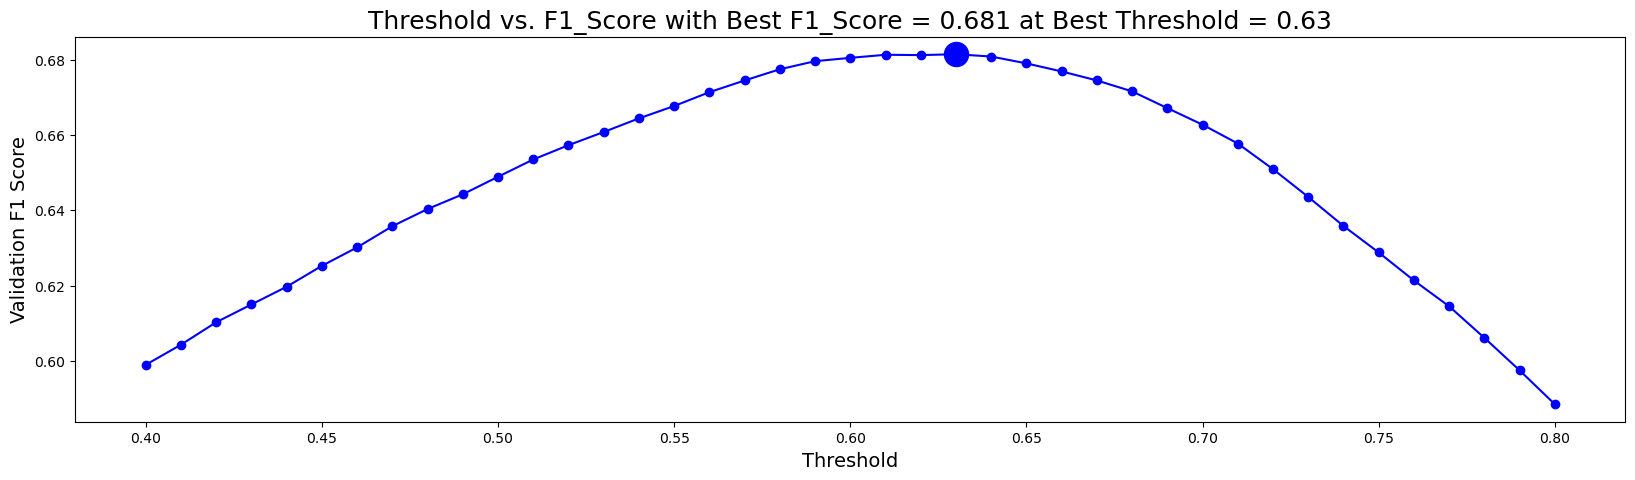

In [229]:
# stealing a plot from another person, but it looks nice

plt.figure(figsize=(20, 5))
plt.plot(thresholds, scores, "-o", color="blue")
plt.scatter([best_threshold], [best_score], color="blue", s=300, alpha=1)
plt.xlabel("Threshold", size=14)
plt.ylabel("Validation F1 Score", size=14)
plt.title(
    f"Threshold vs. F1_Score with Best F1_Score = {best_score:.3f} at Best Threshold = {best_threshold:.3}",
    size=18,
)
plt.show()

In [ ]:
def prep_data(df=None):
    "how to prep the data for the kaggle notebook"
    
    level_dict = {
        '0-4' : [1, 2, 3],
        '5-12' : [4, 5, 6, 7, 8, 9, 10, 11, 12, 13],
        '13-22' : [14, 15, 16, 17, 18]
    }

    
    df_ = df.copy()
    
    # getting elapsed diffs
    df_['event_time_delta'] = (
        df_
        .groupby('session_id')['elapsed_time']
        .transform(lambda x: x.diff().fillna(x.min()))
    )

    # getting the time until the next event
    df_['time_delta_til_next'] = (
        df_
        .groupby('session_id')['elapsed_time']
        .transform(lambda x: abs(x.diff(-1)).fillna(abs(x.min())))
    )
    
    # time delta means    
    time_delta_mean = df_.groupby('session_id').agg(event_time_mean=('event_time_delta', 'mean'),
                                                    event_time_std=('event_time_delta', 'std'),
                                                    event_time_max=('event_time_delta', 'max'))
    
    # total time on each event
    total_time_event = (
        df_
        .groupby(['session_id', 'event_name'])
        .agg(total_time=('time_delta_til_next', 'sum'))
        .unstack()
    )   
    
    # unique text ids
    nunique_text_ids = df_.groupby('session_id')['text_fqid'].nunique()
    
    # unique fqids 
    nunique_fqid = df_.groupby('session_id')['fqid'].nunique()
    
    # how many events of each type occurred in the session
    event_counts = df_.groupby('session_id')['event_name'].value_counts().unstack()
    
    # getting session lengths
    session_lengths = df_.groupby('session_id')['elapsed_time'].max().rename('total_length')
    
    # total events in the session
    session_events = df_.groupby('session_id')['session_id'].count()
    
    # final df pre labels
    df_features = (
        pd.concat([total_time_event, nunique_text_ids, nunique_fqid, event_counts, session_lengths, session_events, time_delta_mean], axis=1)
        .drop(columns='session_id')
        .reset_index()
    )
    
    df_features['year'] = df_features['session_id'].apply(lambda x: int(str(x)[:2]))
    df_features['month'] = df_features['session_id'].apply(lambda x: int(str(x)[2:4]))
    df_features['day'] = df_features['session_id'].apply(lambda x: int(str(x)[4:6]))
    df_features['hour'] = df_features['session_id'].apply(lambda x: int(str(x)[6:8]))

    # # creating a weekend indicator because weekends are different
    df_features['weekend'] = np.where(df_features['day'].isin([6,0]), 1, 0)
    
    return df_features

In [233]:
# saving models
for key in models.keys():
    
    model_ = models[key]
    
    with open(f'model_{key}.pickle', 'wb') as file:
        pickle.dump(model_, file, protocol=4)

In [ ]:
# saving thresholds - no reason to do this separately, TODO
threshold_list = []

for key in models.keys():
    
    threshold_ = models[key][1].round(2)
    threshold_list.append(threshold_)
    
with open('threshold_list.pickle', 'wb') as file:
    pickle.dump(threshold_list, file, protocol=4)

In [ ]:
# saving features
with open('feature_cols_may17.pickle', 'wb') as file:
    pickle.dump(feature_cols, file, protocol=4)

In [150]:
# this cell iterates over the test data 
test_df = pd.read_csv('test.csv')

# defining the questions for each group
limits = {'0-4':(1,4), '5-12':(4,14), '13-22':(14,19)}

for _, tf in test_df.groupby(['session_id', 'level_group']):
    
    # get the level group (to get the data for the model)
    level_group = tf['level_group'].values[0]
    
    # create feature df
    df_ = prep_data(tf)
    
    # figure out if feature columns are missing - important for submission
    missing_columns = list(set(feature_cols) - set(df_.columns))
    
    # create a dataframe with the missing columns filled with 0s (for now)
    missing_df = pd.DataFrame(0, columns=missing_columns, index=df_.index)
    
    # combine the original df and the missing df
    df_ = pd.concat([df_, missing_df], axis=1)
    
    # get the questions to iterate over
    a, b = limits[level_group]  
    
    for question in range(a, b):
        # getting model and threshold for the question
        model_ = models[question][0]
        threshold = models[question][1]
        
        raw_pred_proba = model_.predict_proba(df_[feature_cols])[0, 1]
        final_pred = (raw_pred_proba > threshold).astype(int)
    
    print(final_pred)

1
1
0
1
1
0
1
1
0
